In [11]:
from tensorflow.keras.models import model_from_json
file_prefix = "new_jester_3DCNN_lstm"
def load_model(file_path):
    # Load the model architecture from the JSON file
    with open(file_path + '.json', "r") as json_file:
        model_json = json_file.read()
    
    model = model_from_json(model_json)
    
    # Load weights into the model
    model.load_weights(file_path + '.h5')
    
    return model

# Usage
model = load_model('{}_model'.format(file_prefix))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 36, 32, 32, 36)    2952      
                                                                 
 batch_normalization (Batch  (None, 36, 32, 32, 36)    144       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 36, 16, 16, 36)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 16, 16, 64)    62272     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 16, 16, 64)    256       
 chNormalization)                                                
                                                        

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json

2024-10-18 11:45:05.210149: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 11:45:05.238172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 11:45:05.675476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### importing libraries

In [4]:
import pandas as pd
import numpy as np
from glob import glob
import skimage.transform
from skimage import io
from sklearn.preprocessing import OneHotEncoder
import joblib

import tensorflow as tf

#### Selecting Gestures

In [5]:
gesture_list = ['Swiping Right','Swiping Left','Thumb Up','Thumb Down','No gesture','Zooming In With Full Hand','Zooming Out With Full Hand']

#train
file_prefix = "new_jester_3DCNN_lstm"
df = pd.read_csv('./annotations/jester-v1-train.csv',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_train.csv'.format(file_prefix),sep=';',index=False)
# pd.read_csv('jester-v1-8classes_train.csv',sep=";").head()
print(df.shape)
print(df.head())
#val
df = pd.read_csv('./annotations/jester-v1-validation.csv',sep=';',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_val.csv'.format(file_prefix),sep=';',index=False)
print(df.shape)
print(df.head())

print('Csvs done')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256,256), frames_count=36, n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27,validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path,sep=";")
        self.df.id = self.df.id.map(str)
        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse_output=False)
            self.encoder.fit(self.df.labels.values[:,None])
            joblib.dump(self.encoder,"{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes),self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        ## Decides step_size
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.df.loc[indexes,"id"].to_list()
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.df.shape[0])
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size,self.frames_count, *self.image_dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=str)
        y = []
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID,"id"] + "/*.jpg"),self.df.loc[ID])
            for idx,filename in enumerate(files_list):
                X[i,idx] = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename,color_mode='grayscale',target_size=self.image_dim))
            y.append(self.df.loc[ID,"labels"])
        encoded = self.encoder.transform(np.array(y)[:,None])
        return X,encoded
        
    def standardize_frame_count(self,files,error_check):
        shape = len(files)
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            mid  = len(files)//2
            dup = [files[mid]]*to_add
            files = files[:mid] + dup + files[mid+1:]
        elif shape > self.frames_count:
            to_remove = (shape - self.frames_count)
            to_remove = int(to_remove) if int(to_remove) == to_remove else int(to_remove) + 1
            files = files[to_remove:]
        return files
    
params = {'batch_size': 56,
          'n_classes': len(gesture_list),
          'n_channels': 3,
          'image_dim': (32,32)
          }

# Generators
training_generator = DataGenerator(file_path="{}_train.csv".format(file_prefix),**params)
validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix),**params)


(29819, 2)
        id                      labels
7   136859                    Thumb Up
8    68574               Swiping Right
13   20706                  No gesture
14   42237                  Thumb Down
19  133442  Zooming Out With Full Hand
(3640, 2)
       id                     labels
0    9223                   Thumb Up
2   42920               Swiping Left
3  106485                 Thumb Down
6   35341  Zooming In With Full Hand
7   94928              Swiping Right
Csvs done


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json
#from keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


2024-10-18 10:04:30.709588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 10:04:30.828864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 10:04:30.829291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
input_shape = (36, 32, 32, 3)
weight_decay = 0.00005


#### Creating custom loss function

In [7]:
def custom_categorical_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)  # Prevent log(0)
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv3D, MaxPooling3D, Dropout, Dense, BatchNormalization, Flatten,GlobalAveragePooling3D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [9]:
def build_model(n_classes=7):
    momentum = 0.99
    
    model = Sequential()
    model.add(Conv3D(36, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=input_shape))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    model.add(Conv3D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))
    model.add(BatchNormalization())
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dropout(0.3))  # Reduced dropout rate
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.01)))

    return model

model = build_model(n_classes=len(gesture_list))
#optimizer = SGD(learning_rate=0.0001)
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
h = model.fit(
    training_generator,
    validation_data=validation_generator,
    validation_steps=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]
)

# Save the model
def save_model(model, file_path):
    model_json = model.to_json()
    with open(file_path + '.json', "w") as json_file:
        json_file.write(model_json)
    model.save_weights(file_path + '.h5')

save_model(model, '{}_model'.format(file_prefix))


2024-10-18 10:04:35.420551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 10:04:35.420753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 10:04:35.420837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-10-18 10:04:40.932042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-18 10:05:19.685072: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4b0cab6490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-18 10:05:19.685116: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-18 10:05:19.728548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/532 [..............................] - ETA: 6:24:29 - loss: 2.1716 - accuracy: 0.1607

2024-10-18 10:05:20.108197: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


532/532 [==============================] - ETA: 0s - loss: 1.2845 - accuracy: 0.5266

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


532/532 [==============================] - 327s 534ms/step - loss: 1.2845 - accuracy: 0.5266 - val_loss: 0.9521 - val_accuracy: 0.6585
Epoch 2/50
532/532 [==============================] - 183s 343ms/step - loss: 0.8722 - accuracy: 0.6970 - val_loss: 0.8250 - val_accuracy: 0.7199
Epoch 3/50
532/532 [==============================] - 179s 337ms/step - loss: 0.6927 - accuracy: 0.7782 - val_loss: 0.7021 - val_accuracy: 0.7701
Epoch 4/50
532/532 [==============================] - 181s 339ms/step - loss: 0.5723 - accuracy: 0.8282 - val_loss: 0.7666 - val_accuracy: 0.7606
Epoch 5/50
532/532 [==============================] - 176s 331ms/step - loss: 0.4870 - accuracy: 0.8571 - val_loss: 0.6597 - val_accuracy: 0.7963
Epoch 6/50
532/532 [==============================] - 177s 333ms/step - loss: 0.4172 - accuracy: 0.8865 - val_loss: 0.6152 - val_accuracy: 0.8136
Epoch 7/50
532/532 [==============================] - 180s 338ms/step - loss: 0.3648 - accuracy: 0.9014 - val_loss: 0.7290 - val_accura

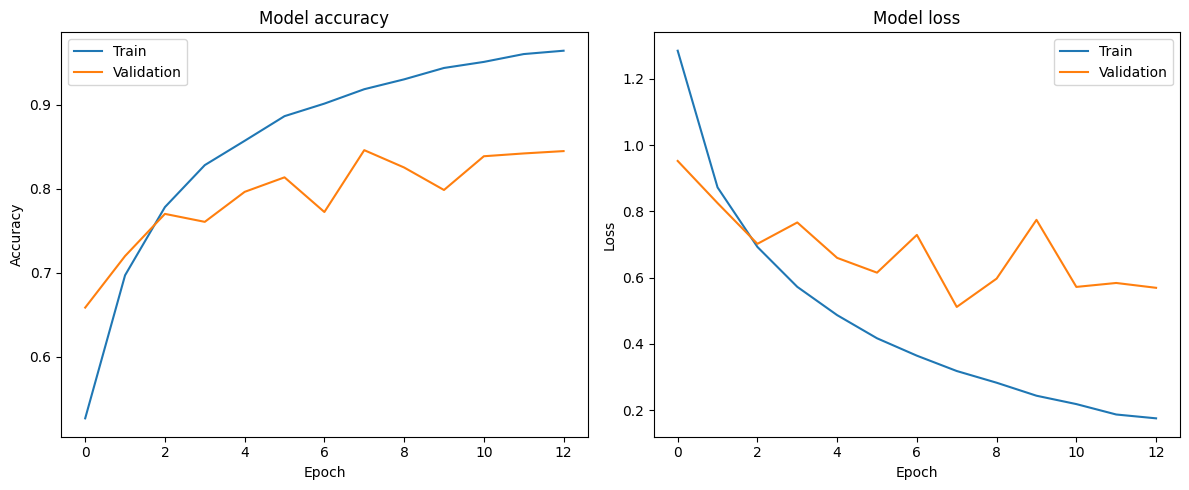

In [10]:
import matplotlib.pyplot as plt  

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [11]:
model.evaluate(validation_generator)


65/65 [==============================] - 20s 312ms/step - loss: 0.5034 - accuracy: 0.8522


[0.5033944249153137, 0.8521978259086609]

- ####  net validation accuracy seems improved, but number of misclassifications between zoom in and zoom out have increased. Check confusion matrix for better understanding